In [1]:
import pandas as pd
import matplotlib.pyplot as plt

special thanks to https://stmorse.github.io/journal/espn-fantasy-projections.html

In [296]:
BASE_URL = "https://fantasy.espn.com/apis/v3/games/ffl/seasons/"

In [3]:
"""
Main communication with ESPN fantasy API
"""
import requests


class ESPNRequests:
    """
    Main communication with ESPN fantasy API

    Args:
        league_id (int): The ID for the fantasy league
        year (int): The year of the league

    Attributes:
        None

    Methods:
        get_league_basic_info (dict): Returns dict of basic league information
        get_league_matchup_info (dict): Returns dict of league matchup information
    """
    def __init__(self, league_id: int, year: int):
        self._league_id: int = league_id
        self._year: int = year

        self._league_url: str = ""

    def _get_current_league_url(self) -> None:
        self._league_url = BASE_URL + f"{self._year}/segments/0/leagues/{self._league_id}"

    def get_league_basic_info(self) -> dict:
        if not self._league_url:
            self._get_current_league_url()

        basic_info_response = requests.get(self._league_url)
        return basic_info_response.json()

    def get_league_matchup_info(self) -> dict:
        if not self._league_url:
            self._get_current_league_url()

        matchups_response = requests.get(self._league_url, params={"view": "mMatchup"})
        return matchups_response.json()


In [4]:
league = ESPNRequests(1117278137, 2021)

In [5]:
league._league_url

''

In [6]:
basic_info = league.get_league_basic_info()

In [7]:
matchup_info = league.get_league_matchup_info()

In [8]:
teams = basic_info["teams"]

In [9]:
def get_team_ids(teams: list) -> list:
    """
    Get list of all team IDs in the league

    Args:
        teams (list): List of dicts of team info

    Returns:
        list: List of all team IDs in the league
    """
    return [team["id"] for team in teams]

In [10]:
team_ids = get_team_ids(teams)

In [11]:
def get_team_scores(
        team_id: int,
        all_games_df: pd.DataFrame,
        avg_scores: pd.DataFrame
) -> pd.DataFrame:
    """
    Get points for/against a given team, centered around league average

    Args:
        team_id (int): A given team ID number
        all_games_df (pd.DataFrame): Dataframe of all league game information
        avg_scores (pd.DataFrame): Dataframe of league average score each week
    """
    # grab all games with this team
    team_games_df = all_games_df.query("Team1 == @team_id | Team2 == @team_id").reset_index(
        drop=True
    )

    # move the team of interest to "Team1" column
    ix = list(team_games_df["Team2"] == team_id)
    team_games_df.loc[ix, ['Team1','Score1','Team2','Score2']] = team_games_df.loc[
        ix, ['Team2','Score2','Team1','Score1']
    ].values

    # add new score and win cols
    team_games_df = team_games_df.assign(
        Chg1 = team_games_df['Score1'] - avg_scores['Score'],
        Chg2 = team_games_df['Score2'] - avg_scores['Score'],
        Win  = team_games_df['Score1'] > team_games_df['Score2']
    )

    return team_games_df

In [12]:
matchups = league.get_league_matchup_info()

In [13]:
games_df = [
    [
        game['matchupPeriodId'],
        game['home']['teamId'], game['home']['totalPoints'],
        game['away']['teamId'], game['away']['totalPoints']
    ]
    for game in matchups['schedule']
]

games_df = pd.DataFrame(games_df, columns=['Week', 'Team1', 'Score1', 'Team2', 'Score2'])

In [14]:
games_df

,Week,Team1,Score1,Team2,Score2
0,1,6,131.76,2,142.66
1,1,5,127.02,7,142.90
2,1,1,86.56,4,119.00
3,1,8,131.68,10,141.64
4,1,3,158.82,9,112.08
...,...,...,...,...,...
70,15,7,0.00,9,0.00
71,15,8,0.00,1,0.00
72,15,6,0.00,5,0.00
73,15,10,0.00,2,0.00


In [15]:
avgs = (
    games_df
    .filter(['Week', 'Score1', 'Score2'])
    .melt(id_vars=['Week'], value_name='Score')
    .groupby('Week')
    .mean()
    .reset_index()
)

In [16]:
avgs = avgs[avgs["Score"]!=0]

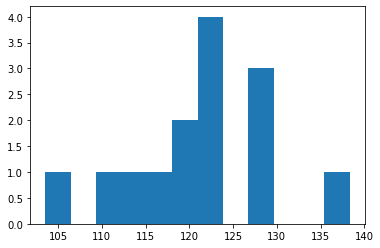

In [17]:
plt.figure()
plt.hist(avgs["Score"], bins=12)
plt.show()

In [18]:
year_avg = avgs["Score"].mean()
year_avg

121.26585714285714

In [19]:
avgs

,Week,Score
0,1,129.412
1,2,128.860
2,3,122.586
3,4,120.196
4,5,138.348
5,6,127.290
6,7,122.648
7,8,113.970
8,9,103.544
9,10,116.072


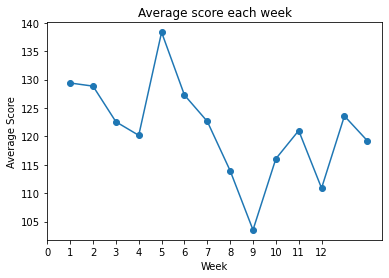

In [20]:
plt.figure()
plt.scatter(avgs["Week"], avgs["Score"])
plt.plot(avgs["Week"], avgs["Score"])
plt.xticks(list(range(13)))
plt.title("Average score each week")
plt.xlabel("Week")
plt.ylabel("Average Score")
plt.show()

In [21]:
teams_df: pd.DataFrame = pd.DataFrame(
    [
        [team["id"], f"{team['location']} {team['nickname']}", team["abbrev"]]
        for team in teams
    ],
    columns=["id", "team name", "abbrev"]
)

teams_df.set_index("id", inplace=True, drop=True)

In [22]:
team_ids

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [23]:
teams_df.loc[team_ids[9 - 1]]["team name"]

'Taylor’s Titans'

In [24]:
get_team_scores(2, games_df, avgs)

,Week,Team1,Score1,Team2,Score2,Chg1,Chg2,Win
0,1,2.0,142.66,6.0,131.76,13.248,2.348,True
1,2,2.0,130.94,7.0,134.06,2.080,5.200,False
2,3,2.0,89.08,4.0,111.38,-33.506,-11.206,False
3,4,2.0,86.46,10.0,165.10,-33.736,44.904,False
4,5,2.0,106.44,9.0,142.02,-31.908,3.672,False
5,6,2.0,127.08,3.0,145.10,-0.210,17.810,False
6,7,2.0,92.84,8.0,111.74,-29.808,-10.908,False
7,8,2.0,114.60,1.0,84.56,0.630,-29.410,True
8,9,2.0,91.96,5.0,90.60,-11.584,-12.944,True
9,10,2.0,143.80,6.0,92.02,27.728,-24.052,True


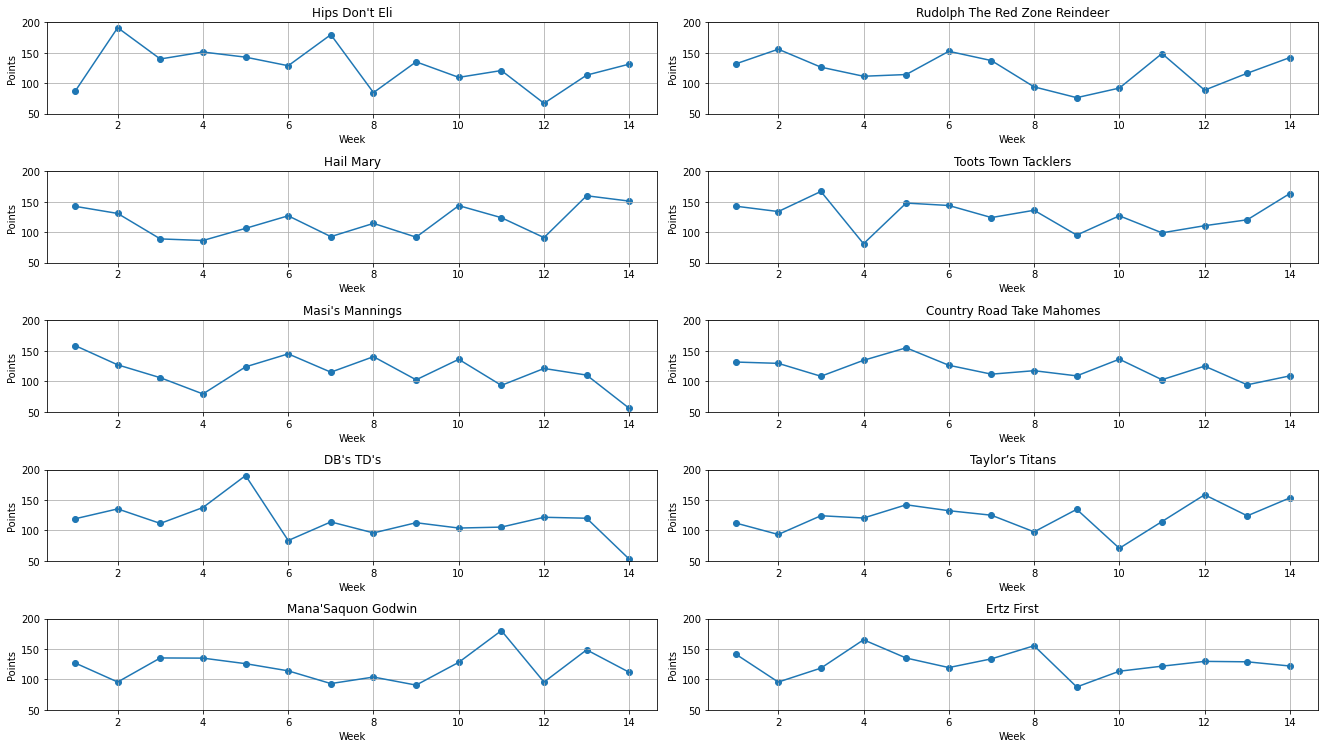

In [25]:
fig, axs = plt.subplots(5, 2)
j = 0

for i in team_ids:
    if i > 5:
        z = i-5
        j = 1
    else:
        z=i

    team_scores = get_team_scores(i, games_df, avgs)
    team_scores = team_scores[team_scores["Score1"]!=0]
    axs[z-1, j].scatter(team_scores["Week"], team_scores["Score1"])
    axs[z-1, j].plot(team_scores["Week"], team_scores["Score1"])
    axs[z-1, j].title.set_text(teams_df.loc[team_ids[i - 1]]["team name"])
    axs[z-1, j].set_ylim([50, 200])
    axs[z-1, j].set_ylabel("Points")
    axs[z-1, j].set_xlabel("Week")
    axs[z-1, j].grid()

fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.savefig("./team_score_trends.png")
plt.show()

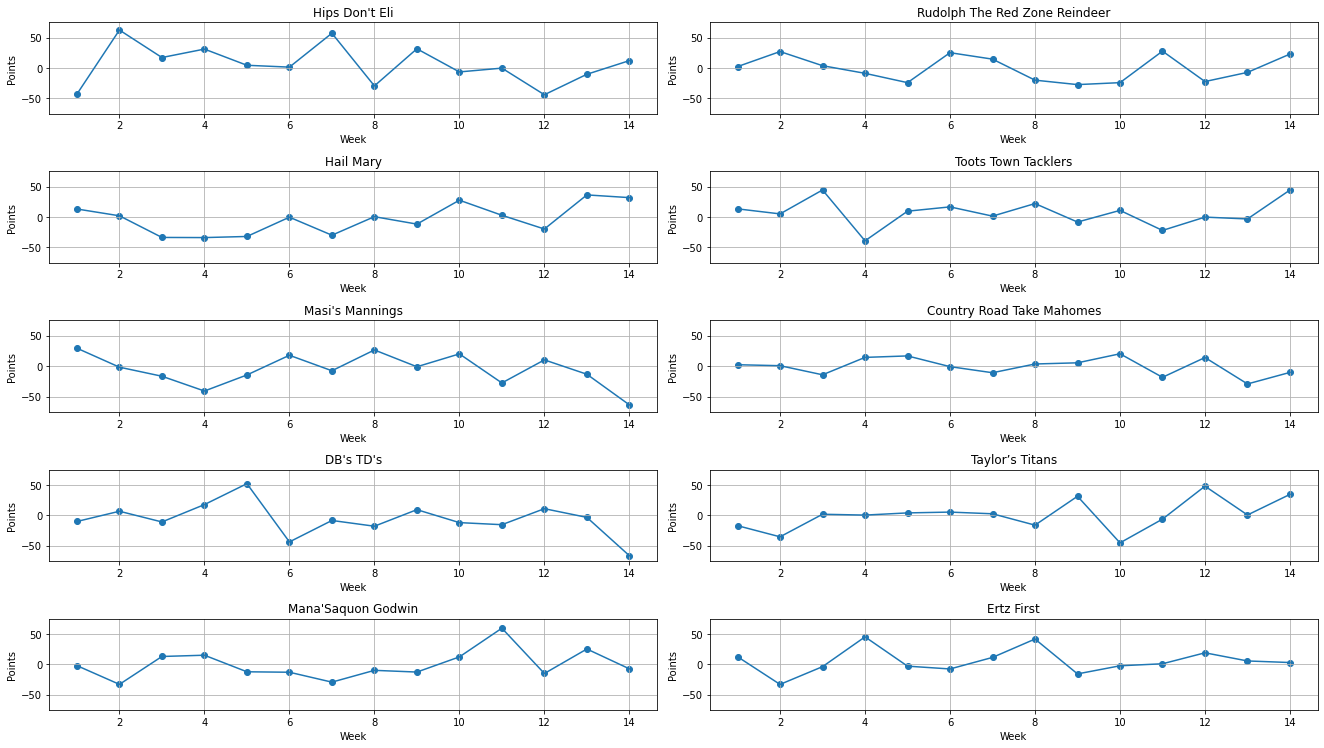

In [26]:
fig, axs = plt.subplots(5, 2)
j = 0

for i in team_ids:
    if i > 5:
        z = i-5
        j = 1
    else:
        z=i

    team_scores = get_team_scores(i, games_df, avgs)
    team_scores = team_scores[team_scores["Score1"]!=0]
    team_score_from_avg = team_scores["Score1"] - avgs["Score"]

    axs[z-1, j].scatter(team_scores["Week"], team_score_from_avg)
    axs[z-1, j].plot(team_scores["Week"], team_score_from_avg)
    axs[z-1, j].title.set_text(teams_df.loc[team_ids[i - 1]]["team name"])
    axs[z-1, j].set_ylim([-75, 75])
    axs[z-1, j].set_ylabel("Points")
    axs[z-1, j].set_xlabel("Week")
    axs[z-1, j].grid()

fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.savefig("./team_score_from_avg_trends.png")
plt.show()

In [27]:
team_scores = get_team_scores(1, games_df, avgs)
team_scores = team_scores[team_scores["Score1"]!=0]
team_score_from_avg = team_scores["Score1"] - avgs["Score"]

In [28]:
team_score_from_avg.sum()

84.69800000000004

In [29]:
diff_from_avgs = {}
team_scores_from_avg = {}

for i in team_ids:
    team_name = teams_df.loc[team_ids[i - 1]]["team name"]
    
    team_scores = get_team_scores(i, games_df, avgs)
    team_scores = team_scores[team_scores["Score1"]!=0]
    team_score_from_avg = team_scores["Score1"] - avgs["Score"]
    team_scores_from_avg[team_name] = team_score_from_avg
    
    diff_from_avg = team_score_from_avg.sum()
    diff_from_avgs[team_name] = diff_from_avg

In [30]:
pd.Series(diff_from_avgs).sort_values(ascending=False)

Toots Town Tacklers              96.318
Hips Don't Eli                   84.698
Ertz First                       69.938
Taylor’s Titans                   3.958
Country Road Take Mahomes        -7.002
Rudolph The Red Zone Reindeer    -9.742
Mana'Saquon Godwin              -13.402
Hail Mary                       -45.402
Masi's Mannings                 -83.482
DB's TD's                       -95.882
dtype: float64

In [31]:
team_scores_from_avg_df = pd.DataFrame.from_dict(team_scores_from_avg, orient="index")

In [32]:
team_scores_from_avg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Hips Don't Eli,-42.852,62.44,17.254,31.124,4.512,1.47,57.192,-29.41,31.616,-6.432,-0.176,-43.918,-10.282,12.16
Hail Mary,13.248,2.08,-33.506,-33.736,-31.908,-0.21,-29.808,0.63,-11.584,27.728,2.944,-19.658,36.418,31.96
Masi's Mannings,29.408,-1.78,-16.666,-40.976,-14.568,17.81,-7.648,26.53,-1.064,20.068,-27.696,10.202,-13.382,-63.72
DB's TD's,-10.412,6.40,-11.206,17.344,51.732,-44.01,-8.768,-18.21,8.996,-12.292,-15.696,10.602,-3.682,-66.68
Mana'Saquon Godwin,-2.392,-33.18,12.654,14.744,-12.508,-13.25,-29.528,-10.13,-12.944,11.968,59.164,-15.318,24.958,-7.64
Rudolph The Red Zone Reindeer,2.348,27.06,3.834,-8.736,-24.068,25.21,14.592,-19.95,-27.264,-24.052,27.744,-22.238,-7.162,22.94
Toots Town Tacklers,13.488,5.20,44.534,-39.076,9.652,16.73,1.532,22.19,-8.184,10.968,-21.976,-0.098,-3.102,44.46
Country Road Take Mahomes,2.268,0.66,-14.286,14.324,16.732,-0.91,-10.908,3.47,5.396,20.268,-18.436,14.102,-29.342,-10.34
Taylor’s Titans,-17.332,-35.64,1.454,0.084,3.672,5.01,2.232,-16.45,31.016,-45.572,-6.556,47.622,0.278,34.14
Ertz First,12.228,-33.24,-4.066,44.904,-3.248,-7.85,11.112,41.33,-15.984,-2.652,0.684,18.702,5.298,2.72


In [33]:
team_scores_from_avg_df["std"] = team_scores_from_avg_df.std(axis=1)

In [34]:
team_scores_from_avg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,std
Hips Don't Eli,-42.852,62.44,17.254,31.124,4.512,1.47,57.192,-29.41,31.616,-6.432,-0.176,-43.918,-10.282,12.16,32.664709
Hail Mary,13.248,2.08,-33.506,-33.736,-31.908,-0.21,-29.808,0.63,-11.584,27.728,2.944,-19.658,36.418,31.96,24.567478
Masi's Mannings,29.408,-1.78,-16.666,-40.976,-14.568,17.81,-7.648,26.53,-1.064,20.068,-27.696,10.202,-13.382,-63.72,26.505532
DB's TD's,-10.412,6.40,-11.206,17.344,51.732,-44.01,-8.768,-18.21,8.996,-12.292,-15.696,10.602,-3.682,-66.68,27.722831
Mana'Saquon Godwin,-2.392,-33.18,12.654,14.744,-12.508,-13.25,-29.528,-10.13,-12.944,11.968,59.164,-15.318,24.958,-7.64,24.027096
Rudolph The Red Zone Reindeer,2.348,27.06,3.834,-8.736,-24.068,25.21,14.592,-19.95,-27.264,-24.052,27.744,-22.238,-7.162,22.94,21.143024
Toots Town Tacklers,13.488,5.20,44.534,-39.076,9.652,16.73,1.532,22.19,-8.184,10.968,-21.976,-0.098,-3.102,44.46,22.499339
Country Road Take Mahomes,2.268,0.66,-14.286,14.324,16.732,-0.91,-10.908,3.47,5.396,20.268,-18.436,14.102,-29.342,-10.34,14.596330
Taylor’s Titans,-17.332,-35.64,1.454,0.084,3.672,5.01,2.232,-16.45,31.016,-45.572,-6.556,47.622,0.278,34.14,25.421115
Ertz First,12.228,-33.24,-4.066,44.904,-3.248,-7.85,11.112,41.33,-15.984,-2.652,0.684,18.702,5.298,2.72,20.550092


In [35]:
team_scores_from_avg_df["mean"] = team_scores_from_avg_df.loc[:, :11].mean(axis=1)

In [36]:
team_scores_from_avg_df["median"] = team_scores_from_avg_df.loc[:, :11].median(axis=1)

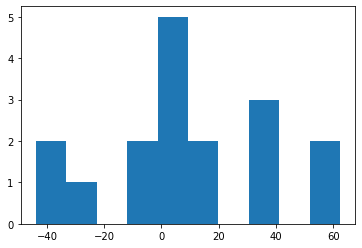

In [37]:
plt.figure()
plt.hist(team_scores_from_avg_df.loc["Hips Don't Eli", :])
plt.show()

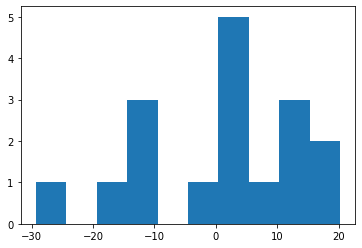

In [38]:
plt.figure()
plt.hist(team_scores_from_avg_df.loc["Country Road Take Mahomes", :])
plt.show()

In [39]:
team_scores_from_avg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,std,mean,median
Hips Don't Eli,-42.852,62.44,17.254,31.124,4.512,1.47,57.192,-29.41,31.616,-6.432,-0.176,-43.918,-10.282,12.16,32.664709,6.901667,2.991
Hail Mary,13.248,2.08,-33.506,-33.736,-31.908,-0.21,-29.808,0.63,-11.584,27.728,2.944,-19.658,36.418,31.96,24.567478,-9.481667,-5.897
Masi's Mannings,29.408,-1.78,-16.666,-40.976,-14.568,17.81,-7.648,26.53,-1.064,20.068,-27.696,10.202,-13.382,-63.72,26.505532,-0.531667,-1.422
DB's TD's,-10.412,6.40,-11.206,17.344,51.732,-44.01,-8.768,-18.21,8.996,-12.292,-15.696,10.602,-3.682,-66.68,27.722831,-2.126667,-9.590
Mana'Saquon Godwin,-2.392,-33.18,12.654,14.744,-12.508,-13.25,-29.528,-10.13,-12.944,11.968,59.164,-15.318,24.958,-7.64,24.027096,-2.560000,-11.319
Rudolph The Red Zone Reindeer,2.348,27.06,3.834,-8.736,-24.068,25.21,14.592,-19.95,-27.264,-24.052,27.744,-22.238,-7.162,22.94,21.143024,-2.126667,-3.194
Toots Town Tacklers,13.488,5.20,44.534,-39.076,9.652,16.73,1.532,22.19,-8.184,10.968,-21.976,-0.098,-3.102,44.46,22.499339,4.580000,7.426
Country Road Take Mahomes,2.268,0.66,-14.286,14.324,16.732,-0.91,-10.908,3.47,5.396,20.268,-18.436,14.102,-29.342,-10.34,14.596330,2.723333,2.869
Taylor’s Titans,-17.332,-35.64,1.454,0.084,3.672,5.01,2.232,-16.45,31.016,-45.572,-6.556,47.622,0.278,34.14,25.421115,-2.538333,0.769
Ertz First,12.228,-33.24,-4.066,44.904,-3.248,-7.85,11.112,41.33,-15.984,-2.652,0.684,18.702,5.298,2.72,20.550092,5.160000,-0.984


In [40]:
team_scores_from_avg_df["mean"].sort_values(ascending=False)

Hips Don't Eli                   6.901667
Ertz First                       5.160000
Toots Town Tacklers              4.580000
Country Road Take Mahomes        2.723333
Masi's Mannings                 -0.531667
DB's TD's                       -2.126667
Rudolph The Red Zone Reindeer   -2.126667
Taylor’s Titans                 -2.538333
Mana'Saquon Godwin              -2.560000
Hail Mary                       -9.481667
Name: mean, dtype: float64

In [41]:
team_scores_from_avg_df["std"].sort_values(ascending=False)

Hips Don't Eli                   32.664709
DB's TD's                        27.722831
Masi's Mannings                  26.505532
Taylor’s Titans                  25.421115
Hail Mary                        24.567478
Mana'Saquon Godwin               24.027096
Toots Town Tacklers              22.499339
Rudolph The Red Zone Reindeer    21.143024
Ertz First                       20.550092
Country Road Take Mahomes        14.596330
Name: std, dtype: float64

In [42]:
diff = {}

for i in team_ids:
    team_name = teams_df.loc[team_ids[i - 1]]["team name"]
    max_score = team_scores_from_avg_df.loc[team_name, :11].max()
    min_score = team_scores_from_avg_df.loc[team_name, :11].min()
    
    diff[team_name] = max_score - min_score

In [43]:
pd.Series(diff).sort_values(ascending=False)

Hips Don't Eli                   106.358
DB's TD's                         95.742
Taylor’s Titans                   93.194
Mana'Saquon Godwin                92.344
Toots Town Tacklers               83.610
Ertz First                        78.144
Masi's Mannings                   70.384
Hail Mary                         61.464
Rudolph The Red Zone Reindeer     55.008
Country Road Take Mahomes         38.704
dtype: float64

In [44]:
all_team_scores = {}

for i in team_ids:
    team_name = teams_df.loc[team_ids[i - 1]]["team name"]
    
    team_scores = get_team_scores(i, games_df, avgs)
    all_team_scores[team_name] = team_scores[team_scores["Score1"]!=0]["Score1"]

In [45]:
all_team_scores_df = pd.DataFrame.from_dict(all_team_scores, orient="index")

In [46]:
diff = {}

for i in team_ids:
    team_name = teams_df.loc[team_ids[i - 1]]["team name"]
    max_score = all_team_scores_df.loc[team_name, :11].max()
    min_score = all_team_scores_df.loc[team_name, :11].min()
    
    diff[team_name] = max_score - min_score

In [47]:
pd.Series(diff).sort_values(ascending=False)

Hips Don't Eli                   124.32
DB's TD's                        106.80
Mana'Saquon Godwin                89.60
Taylor’s Titans                   88.02
Toots Town Tacklers               86.00
Rudolph The Red Zone Reindeer     79.64
Masi's Mannings                   79.60
Ertz First                        77.54
Hail Mary                         57.34
Country Road Take Mahomes         52.48
dtype: float64

# MVP

In [50]:
matchup_info.keys()

dict_keys(['draftDetail', 'gameId', 'id', 'schedule', 'scoringPeriodId', 'seasonId', 'segmentId', 'status', 'teams'])

In [57]:
matchup_info["schedule"][0].keys()

dict_keys(['away', 'home', 'id', 'matchupPeriodId', 'winner'])

In [62]:
matchup_info["schedule"][0]["winner"]

'AWAY'

In [66]:
matchup_info["teams"][0].keys()

dict_keys(['id', 'roster'])

In [73]:
len(matchup_info["teams"][0]["roster"]["entries"])

17

In [76]:
len(matchup_info["schedule"])

75

In [78]:
type(matchup_info["schedule"])

list

In [87]:
matchup_info["schedule"][20]["winner"]

'HOME'

In [85]:
matchup_info["schedule"][20]["away"]

{'cumulativeScore': {'losses': 0,
  'scoreByStat': {'128': {'ineligible': False,
    'rank': 0.0,
    'result': None,
    'score': 0.0},
   '129': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '130': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 1.0},
   '3': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 411.0},
   '4': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 5.0},
   '132': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '133': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '134': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '198': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 1.0},
   '135': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '72': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 1.0},
   '136': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '201': {'ineligible': False

In [86]:
teams_df.loc[team_ids[2 - 1]]["team name"]

'Hail Mary'

In [88]:
matchup_info["schedule"][20]["home"]

{'cumulativeScore': {'losses': 0,
  'scoreByStat': {'128': {'ineligible': False,
    'rank': 0.0,
    'result': None,
    'score': 0.0},
   '129': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '130': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '3': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 398.0},
   '4': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 4.0},
   '132': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '133': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '134': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '198': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '135': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 1.0},
   '72': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '136': {'ineligible': False, 'rank': 0.0, 'result': None, 'score': 0.0},
   '201': {'ineligible': False

In [92]:
matchup_info["teams"][9-1]["roster"].keys()

dict_keys(['appliedStatTotal', 'entries'])

In [94]:
matchup_info["teams"][9-1]["roster"]["entries"][0]

{'acquisitionDate': 1631060333937,
 'acquisitionType': 'DRAFT',
 'injuryStatus': 'NORMAL',
 'lineupSlotId': 2,
 'pendingTransactionIds': None,
 'playerId': 3054850,
 'playerPoolEntry': {'appliedStatTotal': 24.5,
  'id': 3054850,
  'keeperValue': 0,
  'keeperValueFuture': 1,
  'lineupLocked': False,
  'onTeamId': 9,
  'player': {'active': True,
   'defaultPositionId': 2,
   'droppable': False,
   'eligibleSlots': [2, 3, 23, 7, 20, 21],
   'firstName': 'Alvin',
   'fullName': 'Alvin Kamara',
   'id': 3054850,
   'injured': False,
   'injuryStatus': 'ACTIVE',
   'lastName': 'Kamara',
   'lastNewsDate': 1639344111000,
   'proTeamId': 18,
   'rankings': {'0': [{'auctionValue': 0,
      'rank': 4,
      'rankSourceId': 7,
      'rankType': 'STANDARD',
      'slotId': 2},
     {'auctionValue': 0,
      'rank': 3,
      'rankSourceId': 7,
      'rankType': 'PPR',
      'slotId': 2},
     {'auctionValue': 0,
      'rank': 3,
      'rankSourceId': 5,
      'rankType': 'STANDARD',
      'slotId':

In [95]:
league._league_url


'https://fantasy.espn.com/apis/v3/games/ffl/seasons/2021/segments/0/leagues/1117278137'

In [97]:
matchups_scores_response = requests.get(league._league_url, params={"view": "mMatchup", "view": "mMatchupScore"})

In [99]:
matchups_scores_response = matchups_scores_response.json()

In [100]:
matchups_scores_response.keys()

dict_keys(['draftDetail', 'gameId', 'id', 'schedule', 'scoringPeriodId', 'seasonId', 'segmentId', 'status'])

In [101]:
matchups_scores_response["schedule"][20].keys()

dict_keys(['away', 'home', 'id', 'matchupPeriodId', 'playoffTierType', 'winner'])

In [102]:
matchups_scores_response["schedule"][20]["away"]

{'adjustment': 0.0,
 'cumulativeScore': {'losses': 0, 'statBySlot': None, 'ties': 0, 'wins': 0},
 'pointsByScoringPeriod': {'5': 106.44},
 'teamId': 2,
 'tiebreak': 0.0,
 'totalPoints': 106.44}

In [106]:
matchups_scores_response["schedule"][0]

{'away': {'adjustment': 0.0,
  'cumulativeScore': {'losses': 0, 'statBySlot': None, 'ties': 0, 'wins': 0},
  'pointsByScoringPeriod': {'1': 142.66},
  'teamId': 2,
  'tiebreak': 0.0,
  'totalPoints': 142.66},
 'home': {'adjustment': 0.0,
  'cumulativeScore': {'losses': 0, 'statBySlot': None, 'ties': 0, 'wins': 0},
  'pointsByScoringPeriod': {'1': 131.76},
  'teamId': 6,
  'tiebreak': 0.0,
  'totalPoints': 131.76},
 'id': 1,
 'matchupPeriodId': 1,
 'playoffTierType': 'NONE',
 'winner': 'AWAY'}

In [108]:
matchups_scores_response["scoringPeriodId"]

15

In [109]:
matchups_scores_response = requests.get(
    league._league_url, params={"view": "mMatchup", "view": "mMatchupScore", 'scoringPeriodId': 1}
)

In [111]:
matchups_scores_response = matchups_scores_response.json()

In [112]:
matchups_scores_response.keys()

dict_keys(['draftDetail', 'gameId', 'id', 'schedule', 'scoringPeriodId', 'seasonId', 'segmentId', 'status'])

In [117]:
matchups_scores_response["schedule"][0]

{'away': {'adjustment': 0.0,
  'cumulativeScore': {'losses': 0, 'statBySlot': None, 'ties': 0, 'wins': 0},
  'pointsByScoringPeriod': {'1': 142.66},
  'rosterForCurrentScoringPeriod': {'appliedStatTotal': 142.66,
   'entries': [{'lineupSlotId': 2,
     'playerPoolEntry': {'player': {'stats': [{'appliedStats': {'53': 4.908143801,
          '72': -0.12052144,
          '24': 6.948748047,
          '25': 4.426079598,
          '26': 0.037227816,
          '42': 4.016258701000001,
          '43': 1.060911792,
          '44': 0.018919524,
          '63': 0.003294},
         'appliedTotal': 21.299061839000004,
         'proTeamId': 0,
         'scoringPeriodId': 1,
         'seasonId': 2021,
         'statSourceId': 1,
         'statSplitTypeId': 1,
         'stats': {'23': 16.3386008,
          '24': 69.48748047,
          '25': 0.737679933,
          '26': 0.018613908,
          '27': 13.0,
          '28': 6.0,
          '29': 3.0,
          '30': 2.0,
          '31': 1.0,
          '33': 

In [120]:
matchups_scores_response["schedule"][0].keys()

dict_keys(['away', 'home', 'id', 'matchupPeriodId', 'playoffTierType', 'winner'])

In [121]:
matchups_scores_response["schedule"][0]["away"].keys()

dict_keys(['adjustment', 'cumulativeScore', 'pointsByScoringPeriod', 'rosterForCurrentScoringPeriod', 'teamId', 'tiebreak', 'totalPoints'])

In [122]:
matchups_scores_response["schedule"][0]["away"]["teamId"]

2

In [129]:
matchups_scores_response["schedule"][0]["away"]["pointsByScoringPeriod"]

{'1': 142.66}

In [131]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"].keys()

dict_keys(['appliedStatTotal', 'entries'])

In [133]:
len(matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"])

16

In [134]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0]

{'lineupSlotId': 2,
 'playerPoolEntry': {'player': {'stats': [{'appliedStats': {'53': 4.908143801,
      '72': -0.12052144,
      '24': 6.948748047,
      '25': 4.426079598,
      '26': 0.037227816,
      '42': 4.016258701000001,
      '43': 1.060911792,
      '44': 0.018919524,
      '63': 0.003294},
     'appliedTotal': 21.299061839000004,
     'proTeamId': 0,
     'scoringPeriodId': 1,
     'seasonId': 2021,
     'statSourceId': 1,
     'statSplitTypeId': 1,
     'stats': {'23': 16.3386008,
      '24': 69.48748047,
      '25': 0.737679933,
      '26': 0.018613908,
      '27': 13.0,
      '28': 6.0,
      '29': 3.0,
      '30': 2.0,
      '31': 1.0,
      '33': 3.0,
      '34': 1.0,
      '35': 0.034491472,
      '36': 0.02414403,
      '37': 0.211302494,
      '38': 0.00721,
      '39': 4.252963966,
      '40': 69.48748047,
      '42': 40.16258701,
      '43': 0.176818632,
      '44': 0.009459762,
      '45': 0.00411672,
      '46': 0.002690276,
      '47': 8.0,
      '48': 4.0,
   

In [135]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0].keys()

dict_keys(['lineupSlotId', 'playerPoolEntry'])

In [136]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0]["playerPoolEntry"].keys()

dict_keys(['player'])

In [137]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0]["playerPoolEntry"]["player"]

{'stats': [{'appliedStats': {'53': 4.908143801,
    '72': -0.12052144,
    '24': 6.948748047,
    '25': 4.426079598,
    '26': 0.037227816,
    '42': 4.016258701000001,
    '43': 1.060911792,
    '44': 0.018919524,
    '63': 0.003294},
   'appliedTotal': 21.299061839000004,
   'proTeamId': 0,
   'scoringPeriodId': 1,
   'seasonId': 2021,
   'statSourceId': 1,
   'statSplitTypeId': 1,
   'stats': {'23': 16.3386008,
    '24': 69.48748047,
    '25': 0.737679933,
    '26': 0.018613908,
    '27': 13.0,
    '28': 6.0,
    '29': 3.0,
    '30': 2.0,
    '31': 1.0,
    '33': 3.0,
    '34': 1.0,
    '35': 0.034491472,
    '36': 0.02414403,
    '37': 0.211302494,
    '38': 0.00721,
    '39': 4.252963966,
    '40': 69.48748047,
    '42': 40.16258701,
    '43': 0.176818632,
    '44': 0.009459762,
    '45': 0.00411672,
    '46': 0.002690276,
    '47': 8.0,
    '48': 4.0,
    '49': 2.0,
    '50': 1.0,
    '53': 4.908143801,
    '56': 0.0528162,
    '57': 0.00163,
    '58': 6.301091118,
    '60': 8.18

In [139]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0]["playerPoolEntry"]["player"]["stats"]

[{'appliedStats': {'53': 4.908143801,
   '72': -0.12052144,
   '24': 6.948748047,
   '25': 4.426079598,
   '26': 0.037227816,
   '42': 4.016258701000001,
   '43': 1.060911792,
   '44': 0.018919524,
   '63': 0.003294},
  'appliedTotal': 21.299061839000004,
  'proTeamId': 0,
  'scoringPeriodId': 1,
  'seasonId': 2021,
  'statSourceId': 1,
  'statSplitTypeId': 1,
  'stats': {'23': 16.3386008,
   '24': 69.48748047,
   '25': 0.737679933,
   '26': 0.018613908,
   '27': 13.0,
   '28': 6.0,
   '29': 3.0,
   '30': 2.0,
   '31': 1.0,
   '33': 3.0,
   '34': 1.0,
   '35': 0.034491472,
   '36': 0.02414403,
   '37': 0.211302494,
   '38': 0.00721,
   '39': 4.252963966,
   '40': 69.48748047,
   '42': 40.16258701,
   '43': 0.176818632,
   '44': 0.009459762,
   '45': 0.00411672,
   '46': 0.002690276,
   '47': 8.0,
   '48': 4.0,
   '49': 2.0,
   '50': 1.0,
   '53': 4.908143801,
   '56': 0.0528162,
   '57': 0.00163,
   '58': 6.301091118,
   '60': 8.182846435,
   '61': 40.16258701,
   '62': 0.02807367,
   

In [140]:
len(matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0]["playerPoolEntry"]["player"]["stats"])

2

In [141]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0]["playerPoolEntry"]["player"]["stats"][0]

{'appliedStats': {'53': 4.908143801,
  '72': -0.12052144,
  '24': 6.948748047,
  '25': 4.426079598,
  '26': 0.037227816,
  '42': 4.016258701000001,
  '43': 1.060911792,
  '44': 0.018919524,
  '63': 0.003294},
 'appliedTotal': 21.299061839000004,
 'proTeamId': 0,
 'scoringPeriodId': 1,
 'seasonId': 2021,
 'statSourceId': 1,
 'statSplitTypeId': 1,
 'stats': {'23': 16.3386008,
  '24': 69.48748047,
  '25': 0.737679933,
  '26': 0.018613908,
  '27': 13.0,
  '28': 6.0,
  '29': 3.0,
  '30': 2.0,
  '31': 1.0,
  '33': 3.0,
  '34': 1.0,
  '35': 0.034491472,
  '36': 0.02414403,
  '37': 0.211302494,
  '38': 0.00721,
  '39': 4.252963966,
  '40': 69.48748047,
  '42': 40.16258701,
  '43': 0.176818632,
  '44': 0.009459762,
  '45': 0.00411672,
  '46': 0.002690276,
  '47': 8.0,
  '48': 4.0,
  '49': 2.0,
  '50': 1.0,
  '53': 4.908143801,
  '56': 0.0528162,
  '57': 0.00163,
  '58': 6.301091118,
  '60': 8.182846435,
  '61': 40.16258701,
  '62': 0.02807367,
  '63': 0.000549,
  '66': 0.095922199,
  '67': 0.02

In [142]:
matchups_scores_response["schedule"][0]["away"]["rosterForCurrentScoringPeriod"]["entries"][0]["playerPoolEntry"]["player"]["stats"][1]

{'appliedStats': {'53': 9.0, '24': 9.8, '42': 8.9},
 'appliedTotal': 27.700000000000003,
 'proTeamId': 29,
 'scoringPeriodId': 1,
 'seasonId': 2021,
 'statSourceId': 0,
 'statSplitTypeId': 1,
 'stats': {'23': 21.0,
  '24': 98.0,
  '27': 19.0,
  '28': 9.0,
  '29': 4.0,
  '30': 3.0,
  '31': 1.0,
  '33': 4.0,
  '34': 2.0,
  '39': 4.667,
  '40': 98.0,
  '41': 9.0,
  '42': 89.0,
  '47': 17.0,
  '48': 8.0,
  '49': 4.0,
  '50': 3.0,
  '51': 1.0,
  '53': 9.0,
  '54': 1.0,
  '58': 9.0,
  '59': 84.0,
  '60': 9.889,
  '61': 89.0,
  '155': 1.0,
  '210': 1.0},
 'variance': {}}

In [145]:
matchup_info["teams"][2-1]["roster"]["entries"][0]["playerPoolEntry"]

{'appliedStatTotal': 14.4,
 'id': 2976212,
 'keeperValue': 0,
 'keeperValueFuture': 2,
 'lineupLocked': False,
 'onTeamId': 2,
 'player': {'active': True,
  'defaultPositionId': 3,
  'droppable': False,
  'eligibleSlots': [3, 4, 5, 23, 7, 20, 21],
  'firstName': 'Stefon',
  'fullName': 'Stefon Diggs',
  'id': 2976212,
  'injured': False,
  'injuryStatus': 'ACTIVE',
  'lastName': 'Diggs',
  'lastNewsDate': 1639361713000,
  'proTeamId': 2,
  'rankings': {'0': [{'auctionValue': 0,
     'rank': 3,
     'rankSourceId': 9,
     'rankType': 'STANDARD',
     'slotId': 4},
    {'auctionValue': 0,
     'rank': 3,
     'rankSourceId': 7,
     'rankType': 'STANDARD',
     'slotId': 4},
    {'auctionValue': 0,
     'rank': 3,
     'rankSourceId': 7,
     'rankType': 'PPR',
     'slotId': 4},
    {'auctionValue': 0,
     'rank': 3,
     'rankSourceId': 5,
     'rankType': 'STANDARD',
     'slotId': 4},
    {'auctionValue': 0,
     'rank': 3,
     'rankSourceId': 6,
     'rankType': 'PPR',
     'slot

In [146]:
url = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/' + \
      str(2021) + '/segments/0/leagues/' + str(1117278137) + \
      '?view=mMatchup&view=mMatchupScore'

In [148]:
r = requests.get(url, params={'scoringPeriodId': 1})

In [149]:
d = r.json()

In [151]:
d.keys()

dict_keys(['draftDetail', 'gameId', 'id', 'schedule', 'scoringPeriodId', 'seasonId', 'segmentId', 'status', 'teams'])

In [152]:
type(d["teams"])

list

In [158]:
team = d["teams"][1]

In [159]:
type(team["roster"]["entries"])

list

In [171]:
team["roster"]["entries"][0]["playerPoolEntry"]["player"]["fullName"]

'Christian McCaffrey'

In [169]:
team["roster"]["entries"][0]["playerPoolEntry"]["player"]["stats"][0]["statSourceId"]

0

In [168]:
team["roster"]["entries"][0]["playerPoolEntry"]["player"]["stats"][0]["appliedTotal"]

90.4

In [173]:
for i in team["roster"]["entries"][0]["playerPoolEntry"]["player"]["stats"]:
    print(i["statSourceId"])
    print(i["appliedTotal"])
    print(i["scoringPeriodId"])
    print()

0
90.4
0

0
127.5
0

1
0.0
0

1
334.30818991200005
0

1
334.94488688200005
0

1
21.299061839000004
1

0
27.700000000000003
1



## Summary
We can filter individual player scores per week (and their projections) for each team. Using this, we can construct a table of each teams roster each week and the points scored.

Players are under the following keys: "teams" -> *team_id_int* -> "roster" -> "entries". Each entry in this list is a different player. We then filter these entries by "playerPoolEntry" -> "player" -> "stats" and lookup the entry where "scoringPeriodId" matches the week of the game. "statSourceId" will tell you if it the projection or actual score (1 is projection, 0 is actual). "appliedTotal" will give you the score.

I think you have the ping the API for each individual week, unfortunately...

In [191]:
slotcodes = {
    0 : 'QB', 2 : 'RB', 4 : 'WR',
    6 : 'TE', 16: 'Def', 17: 'K',
    20: 'Bench', 21: 'IR', 23: 'Flex'
}

In [199]:
week = 13
team_id = 2

In [200]:
r = requests.get(url, params={'scoringPeriodId': week})
d = r.json()

In [201]:
team = d["teams"][team_id-1]

In [195]:
team["roster"]["entries"][0]["lineupSlotId"]

4

In [203]:
team["roster"]["entries"][0]["playerPoolEntry"]["player"]["id"]

2976212

In [219]:
team_stats = {}

for player in team["roster"]["entries"]:
    player_id = player["playerPoolEntry"]["player"]["id"]
    full_name = player["playerPoolEntry"]["player"]["fullName"]
    position = player["lineupSlotId"]
    position = slotcodes.get(position, "N/A")
    
    for stat in player["playerPoolEntry"]["player"]["stats"]:
        if stat["scoringPeriodId"] == week:
            if stat["statSourceId"] == 1:
                projected_score = stat["appliedTotal"]
            elif stat["statSourceId"] == 0:
                actual_score = stat["appliedTotal"]
                
    team_stats[player_id] = {
        "name": full_name, "projected_score": projected_score, "actual_score": actual_score,
        "position": position, "week": week,
        "fantasy_team_id": team_id,
        "fantasy_team_name": teams_df.loc[team_id]["team name"]
    }

In [220]:
pd.DataFrame.from_dict(team_stats, orient="index")

,name,projected_score,actual_score,position,week,fantasy_team_id,fantasy_team_name
2976212,Stefon Diggs,17.267518,9.10,WR,13,2,Hail Mary
3040151,George Kittle,13.293549,39.60,TE,13,2,Hail Mary
2577327,Tyler Lockett,13.429576,19.80,Bench,13,2,Hail Mary
8439,Aaron Rodgers,0.000000,19.80,Bench,13,2,Hail Mary
3119195,Chase Edmonds,0.000000,0.00,IR,13,2,Hail Mary
2330,Tom Brady,20.889988,28.62,QB,13,2,Hail Mary
13981,Mark Ingram II,14.910339,3.60,Bench,13,2,Hail Mary
15072,Marvin Jones Jr.,10.170018,3.10,Bench,13,2,Hail Mary
4035170,Marquez Callaway,7.899706,2.30,Bench,13,2,Hail Mary
3135321,Hunter Renfrow,13.814329,19.20,Flex,13,2,Hail Mary


In [266]:
all_team_stats = {}

for week in range(1, 15):
    r = requests.get(url, params={'scoringPeriodId': week})
    d = r.json()
    
    for team_id in range(1, 11):
        team_stats = {}

        if team_id not in all_team_stats:
            all_team_stats[team_id] = {}

        all_team_stats[team_id][week] = team_stats

        team = d["teams"][team_id-1]
        
        for player in team["roster"]["entries"]:
            player_id = player["playerPoolEntry"]["player"]["id"]
            full_name = player["playerPoolEntry"]["player"]["fullName"]
            position = player["lineupSlotId"]
            position = slotcodes.get(position, "N/A")

            for stat in player["playerPoolEntry"]["player"]["stats"]:
                if stat["scoringPeriodId"] == week:
                    if stat["statSourceId"] == 1:
                        projected_score = stat["appliedTotal"]
                    elif stat["statSourceId"] == 0:
                        actual_score = stat["appliedTotal"]

            team_stats[player_id] = {
                "player_id": player_id,
                "name": full_name,
                "projected_score": projected_score, "actual_score": actual_score,
                "position": position,
                "week": week,
                "fantasy_team_id": team_id,
                "fantasy_team_name": teams_df.loc[team_id]["team name"]
            }

In [271]:
all_team_stats[1].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [273]:
pd.DataFrame.from_dict(
    all_team_stats[1][1],
    orient="index"
).reset_index().head(30)

,index,player_id,name,projected_score,actual_score,position,week,fantasy_team_id,fantasy_team_name
0,3043078,3043078,Derrick Henry,17.346962,10.70,RB,1,1,Hips Don't Eli
1,4241457,4241457,Najee Harris,14.688001,5.90,RB,1,1,Hips Don't Eli
2,3121422,3121422,Terry McLaurin,14.983161,10.20,WR,1,1,Hips Don't Eli
3,16737,16737,Mike Evans,14.983875,5.40,WR,1,1,Hips Don't Eli
4,4360438,4360438,Brandon Aiyuk,13.937284,0.00,Flex,1,1,Hips Don't Eli
5,3917315,3917315,Kyler Murray,22.165698,33.56,QB,1,1,Hips Don't Eli
6,3054212,3054212,Jonnu Smith,9.000588,9.80,TE,1,1,Hips Don't Eli
7,4243160,4243160,Laviska Shenault Jr.,12.003529,12.90,Bench,1,1,Hips Don't Eli
8,4362628,4362628,Ja'Marr Chase,10.426623,20.90,Bench,1,1,Hips Don't Eli
9,4040715,4040715,Jalen Hurts,19.647925,28.76,Bench,1,1,Hips Don't Eli


In [274]:
pd.DataFrame.from_dict(
    all_team_stats[1][2],
    orient="index"
).reset_index().head(30)

,index,player_id,name,projected_score,actual_score,position,week,fantasy_team_id,fantasy_team_name
0,3043078,3043078,Derrick Henry,18.493062,47.7,RB,2,1,Hips Don't Eli
1,4241457,4241457,Najee Harris,18.649326,19.1,RB,2,1,Hips Don't Eli
2,3121422,3121422,Terry McLaurin,14.666092,27.7,WR,2,1,Hips Don't Eli
3,16737,16737,Mike Evans,13.672055,24.5,Flex,2,1,Hips Don't Eli
4,4360438,4360438,Brandon Aiyuk,9.602044,1.6,Bench,2,1,Hips Don't Eli
5,3917315,3917315,Kyler Murray,21.473667,33.1,QB,2,1,Hips Don't Eli
6,3054212,3054212,Jonnu Smith,8.665134,6.8,TE,2,1,Hips Don't Eli
7,4243160,4243160,Laviska Shenault Jr.,11.586955,1.7,Bench,2,1,Hips Don't Eli
8,4362628,4362628,Ja'Marr Chase,13.270093,13.4,WR,2,1,Hips Don't Eli
9,4040715,4040715,Jalen Hurts,18.917199,21.8,Bench,2,1,Hips Don't Eli


In [281]:
team1_week2 = pd.DataFrame.from_dict(
    all_team_stats[1][2],
    orient="index"
).reset_index()

team1_week2.loc[team1_week2['actual_score'] == team1_week2['actual_score'].max()].iloc[0]["name"]

'Derrick Henry'

In [294]:
for i in range(1, 11):


    max_players = {}
    for week_num, week in all_team_stats[1].items():
        df = pd.DataFrame.from_dict(
            week,
            orient="index"
        ).reset_index()

        best_player = df.loc[df["actual_score"]==df["actual_score"].max()].iloc[0]["name"]
        max_players[week_num] = best_player

    max_players_df = pd.DataFrame.from_dict(max_players, orient="index")

    print("TEAM ID: {}".format(i))
    print(max_players_df.value_counts())
    print()

TEAM ID: 1
Derrick Henry       3
Najee Harris        3
Keenan Allen        2
Kyler Murray        2
Cam Newton          1
D'Ernest Johnson    1
Ja'Marr Chase       1
Terry McLaurin      1
dtype: int64

TEAM ID: 2
Derrick Henry       3
Najee Harris        3
Keenan Allen        2
Kyler Murray        2
Cam Newton          1
D'Ernest Johnson    1
Ja'Marr Chase       1
Terry McLaurin      1
dtype: int64

TEAM ID: 3
Derrick Henry       3
Najee Harris        3
Keenan Allen        2
Kyler Murray        2
Cam Newton          1
D'Ernest Johnson    1
Ja'Marr Chase       1
Terry McLaurin      1
dtype: int64

TEAM ID: 4
Derrick Henry       3
Najee Harris        3
Keenan Allen        2
Kyler Murray        2
Cam Newton          1
D'Ernest Johnson    1
Ja'Marr Chase       1
Terry McLaurin      1
dtype: int64

TEAM ID: 5
Derrick Henry       3
Najee Harris        3
Keenan Allen        2
Kyler Murray        2
Cam Newton          1
D'Ernest Johnson    1
Ja'Marr Chase       1
Terry McLaurin      1
dtype: in

In [292]:
pd.DataFrame.from_dict(max_players, orient="index").value_counts()

Derrick Henry       3
Najee Harris        3
Keenan Allen        2
Kyler Murray        2
Cam Newton          1
D'Ernest Johnson    1
Ja'Marr Chase       1
Terry McLaurin      1
dtype: int64